# CDEC Radius Analysis

In [11]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [7]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [8]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

## Load in the Data

In [14]:
atl06sr_gdf = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../data/aso_dates.pkl', 'rb'))

## Clip ATL06 data to the buffer

<AxesSubplot:>

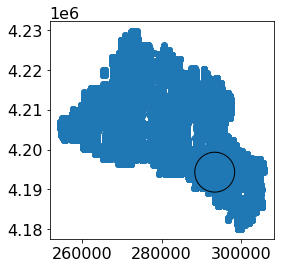

In [28]:
fig, ax = plt.subplots()
atl06sr_gdf.plot(ax=ax)
gdf_center.plot(ax=ax, facecolor='none')

In [29]:
atl06sr_gdf.head(2)

,h_sigma,pflags,segment_id,h_mean,dh_fit_dx,distance,rms_misfit,gt,cycle,delta_time,dh_fit_dy,n_fit_photons,rgt,w_surface_window_final,spot,acqdate,doy,decyear,dowy,snow_presence,platform,site,lidar_z,difference,slope_3m,slope_10m,slope_100m,diff_plus,ASO_snowon,ASO_snowon_date,ASO_snowon_20m,zscore,geometry
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965,0.033182,0,210188,2501.377184,-0.018228,4.215353e+06,0.091912,30,1,2.488094e+07,0.0,15,265,3.0,4,2018-10-15,288,2018.788969,15,0,SlideRule,tuolumne,2501.669922,-0.292738,1.725123,0.962873,NaN,-0.179735,NaN,NaT,NaN,-0.053166,POINT (269304.074 4196719.705)
2018-10-15 23:22:20.021811,0.028329,0,210189,2501.116873,-0.010939,4.215373e+06,0.109110,30,1,2.488094e+07,0.0,18,265,3.0,4,2018-10-15,288,2018.788969,15,0,SlideRule,tuolumne,2501.169922,-0.053049,4.888882,1.995975,NaN,0.059954,NaN,NaT,NaN,-0.036172,POINT (269302.684 4196739.709)


In [78]:
gdf_center[gdf_center['Location']=='tum']

,Location,geometry
0,tum,"POLYGON ((298306.562 4194327.335, 298282.486 4..."


In [31]:
atl06sr_gdf_tum5 = gpd.overlay(atl06sr_gdf, gdf_center[gdf_center['Location']=='tum'], how='intersection')

In [79]:
atl06sr_gdf_dan5 = gpd.overlay(atl06sr_gdf, gdf_center[gdf_center['Location']=='dan'], how='intersection')

<AxesSubplot:>

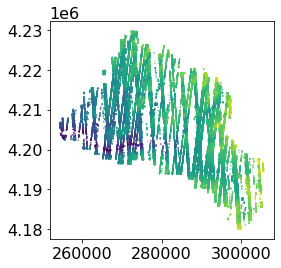

In [82]:
atl06sr_gdf.plot(column='h_mean', markersize=0.05)

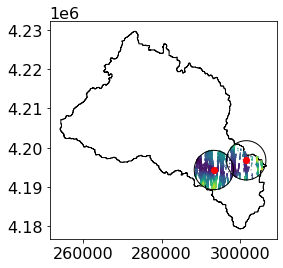

In [80]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax, facecolor='none')
atl06sr_gdf_tum5.plot(ax=ax, column='h_mean', c='y', markersize=0.05)
atl06sr_gdf_dan5.plot(ax=ax, column='h_mean', c='y', markersize=0.05)
gdf_center.plot(ax=ax, facecolor='none')
cdec_gdf.plot(ax=ax, c='r');

In [94]:
aso_gdf = gpd.read_file('../../data/aso_dates.geojson')

In [95]:
aso_gdf.date = pd.DatetimeIndex(aso_gdf.date)
aso_gdf = aso_gdf.set_index(['date'])
aso_gdf.sort_index(inplace=True)
aso_gdf['acqdate'] = aso_gdf.index.date

In [96]:
aso_gdf.head(2)

,fn,platform,doy,decyear,dowy,acqdate,site,geometry
date,,,,,,,,
2019-03-24,../../data/lidar/tuolumne/snow_on/raw/ASO_3M_S...,ASO,83,2019.224658,175,2019-03-24,tuolumne,"POLYGON ((242715.000 4234848.000, 242715.000 4..."
2019-04-17,../../data/lidar/tuolumne/snow_on/raw/ASO_3M_S...,ASO,107,2019.290411,199,2019-04-17,tuolumne,"POLYGON ((254694.878 4234848.000, 254694.878 4..."


In [97]:
df_list = [aso_gdf, atl06sr_gdf_tum5, atl06sr_gdf_dan5,]

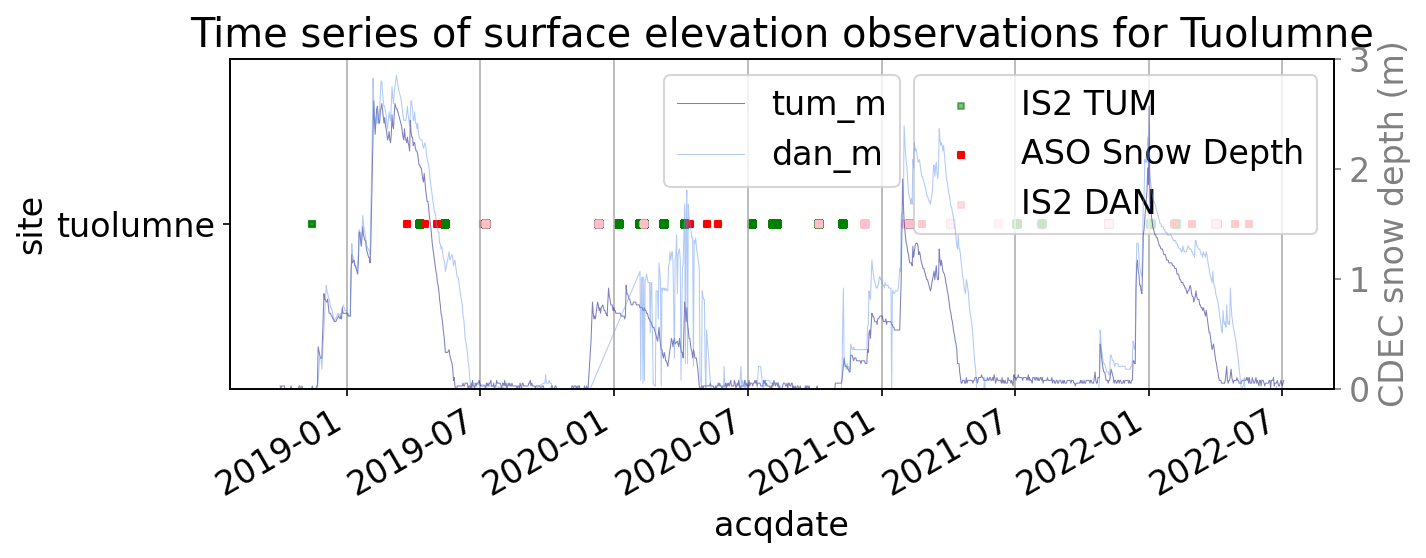

In [100]:
f, ax = plt.subplots(figsize=(10,4), dpi=150)
mykw = {'s':10, 'marker':'s', 'kind':'scatter'}

pd.DataFrame(df_list[1].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='g', label='IS2 TUM', **mykw)
pd.DataFrame(df_list[0].drop(columns='geometry')).plot(ax=ax, x='acqdate', y='site', color='r', label='ASO Snow Depth', **mykw)
pd.DataFrame(df_list[2].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='pink', label='IS2 DAN', **mykw)

ax1 = ax.twinx()
snwd[snwd['tum_m'] < 2.9]['tum_m'].plot(ax=ax1, alpha=0.5, color='navy', lw=0.5, style='-')
snwd[snwd['dan_m'] < 2.9]['dan_m'].plot(ax=ax1, alpha=0.5, color='cornflowerblue', lw=0.5, style='-')
ax1.set_ylabel('CDEC snow depth (m)', color='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylim(0,3)
plt.legend(loc='best')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()
ax.grid(axis='x', which='major')
ax.set_title('Time series of surface elevation observations for Tuolumne')
plt.tight_layout()

In [31]:
atl06sr_gdf_tum5[atl06sr_gdf_tum5['snow_presence']==0]['difference'].describe()

count    5178.000000
mean       -0.071037
std         1.326416
min        -9.165172
25%        -0.463374
50%        -0.147880
75%         0.232288
max        68.208479
Name: difference, dtype: float64

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [84]:
atl06sr_gdf_tum5['zscore'] = (atl06sr_gdf_tum5['diff_plus'] - atl06sr_gdf_tum5['diff_plus'].mean()) / atl06sr_gdf_tum5['diff_plus'].std()
atl06sr_gdf_dan5['zscore'] = (atl06sr_gdf_dan5['diff_plus'] - atl06sr_gdf_dan5['diff_plus'].mean()) / atl06sr_gdf_dan5['diff_plus'].std()
zscore_thresh = 3
absdiff_thresh = 5.0

In [34]:
atl06_idx = (atl06sr_gdf_tum5['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf_tum5['diff_plus'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf_tum5['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf_tum5['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf_tum5['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf_tum5['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf_tum5['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf_tum5['snow_presence'] == 1)

In [35]:
atl06sr_gdf_tum5[atl06_idx]['diff_plus'].describe()

count    19341.000000
mean         0.674982
std          0.990235
min         -3.126875
25%          0.049117
50%          0.586033
75%          1.175788
max          4.528696
Name: diff_plus, dtype: float64

In [36]:
atl06sr_gdf_tum5[inner_snowoff_idx]['diff_plus'].describe()

count    5139.000000
mean        0.050151
std         0.761408
min        -3.082084
25%        -0.345280
50%        -0.031572
75%         0.346404
max         4.485999
Name: diff_plus, dtype: float64

In [37]:
atl06sr_gdf_tum5[inner_snowon_idx]['diff_plus'].describe()

count    14202.000000
mean         0.901078
std          0.966049
min         -3.126875
25%          0.361239
50%          0.782346
75%          1.372001
max          4.528696
Name: diff_plus, dtype: float64

In [85]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [86]:
mpl_epoch = '1970-01-01'
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-05-01'

In [92]:
def boxplot_date(df, df1, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', clim=(-5, 5), name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 TUM stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_width = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_width = 20*bp_width/bp_width.max()+5
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ATL06 DAN stats
    bp_stats1 = df1[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list1 = [i[0] for i in bp_stats1.values]
    bp_width1 = df1[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_width1 = 20*bp_width1/bp_width1.max()+5
    pos1 = (pd.to_datetime(bp_stats1.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_width2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_width2 = 20*bp_width2/bp_width2.max()+5
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'c':'black'},  medianprops={'c':'green', 'lw':2},widths=bp_width)
    # Plot the DAN data
    bxp_f1 = ax.bxp(bp_stats_list1, positions=pos1, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'c':'pink'},  medianprops={'c':'red', 'lw':2},widths=bp_width1)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1, 'c':'magenta'}, medianprops={'c':'orange', 'lw':2}, widths=bp_width2)
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=2)
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=2)
    
    #cso['depth_m'].plot(ax=ax, linestyle='none', marker='.', color='k', markersize=5)
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Elevation difference (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    plt.title('5 km Radius')
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)

In [41]:
atl06sr_gdf_tum5[atl06sr_gdf_tum5['snow_presence'] == 0]['difference'].describe()

count    5178.000000
mean       -0.071037
std         1.326416
min        -9.165172
25%        -0.463374
50%        -0.147880
75%         0.232288
max        68.208479
Name: difference, dtype: float64

In [38]:
type(atl06sr_gdf['snow_presence'][0])

numpy.int64

In [39]:
atl06sr_gdf.head(2)

,h_sigma,pflags,segment_id,h_mean,dh_fit_dx,distance,rms_misfit,gt,cycle,delta_time,dh_fit_dy,n_fit_photons,rgt,w_surface_window_final,spot,acqdate,doy,decyear,dowy,snow_presence,platform,site,lidar_z,difference,slope_3m,slope_10m,slope_100m,diff_plus,ASO_snowon,ASO_snowon_date,ASO_snowon_20m,zscore,Location,geometry
0,0.054840,0,210125,2587.444770,-0.018003,4.214081e+06,0.153952,40,1,2.738152e+07,0.0,68,707,3.0,3,2018-11-13,317,2018.868262,44,0,SlideRule,tuolumne,2588.691895,-1.247125,10.612905,2.909689,0.27292,-1.134122,NaN,NaT,NaN,-1.438406,center,POINT (292318.567 4194846.152)
1,0.013356,0,210126,2587.231692,-0.002520,4.214101e+06,0.146350,40,1,2.738152e+07,0.0,139,707,3.0,3,2018-11-13,317,2018.868262,44,0,SlideRule,tuolumne,2587.623047,-0.391355,0.202440,1.130302,0.27292,-0.278352,NaN,NaT,NaN,-0.767890,center,POINT (292317.156 4194866.152)


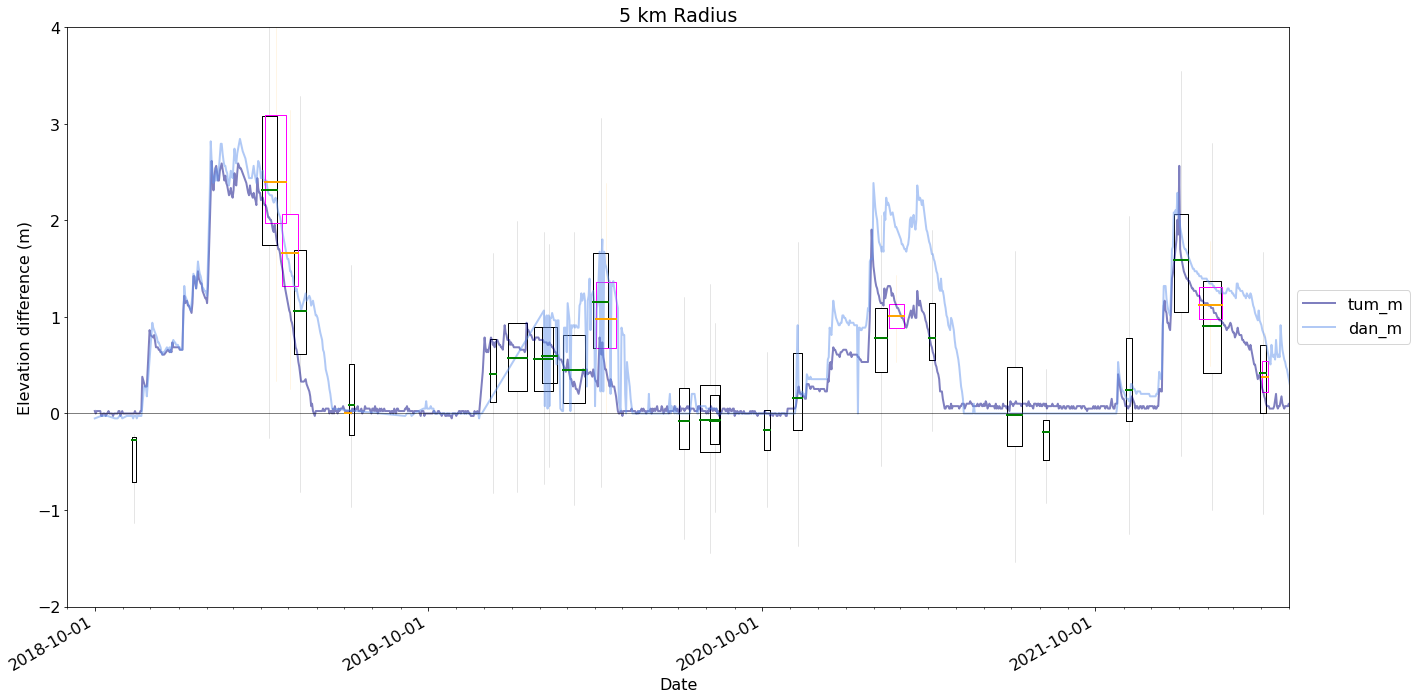

In [42]:
boxplot_date(atl06sr_gdf_tum5, 'diff_plus', 'ASO_snowon', clim=(-2,4), name = '../figures/boxplots_cdec_aso_radius5.jpeg')

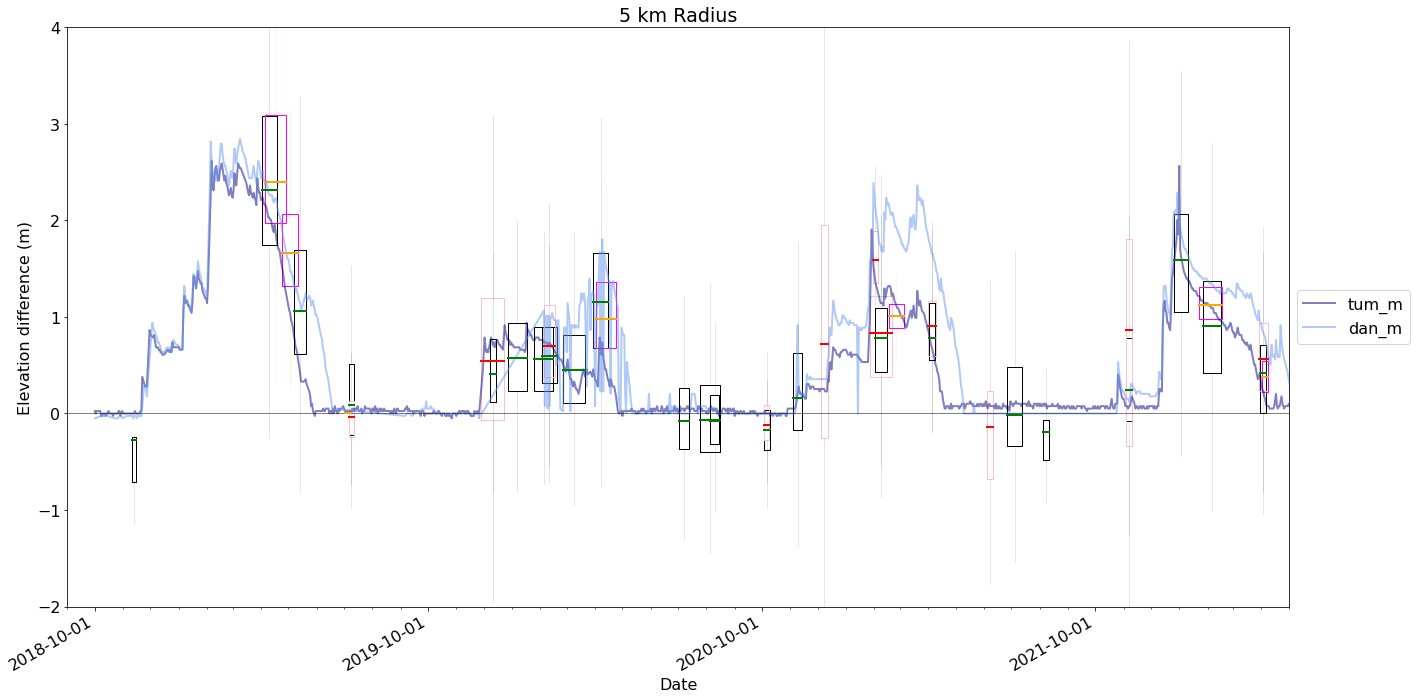

In [93]:
boxplot_date(atl06sr_gdf_tum5, atl06sr_gdf_dan5, 'diff_plus', 'ASO_snowon', clim=(-2,4), name = '../figures/boxplots_cdec_aso_radius5.jpeg')

In [107]:
atl06sr_gdf.head(2)

,h_sigma,pflags,segment_id,h_mean,dh_fit_dx,distance,rms_misfit,gt,cycle,delta_time,dh_fit_dy,n_fit_photons,rgt,w_surface_window_final,spot,acqdate,doy,decyear,dowy,snow_presence,platform,site,lidar_z,difference,slope_3m,slope_10m,slope_100m,diff_plus,ASO_snowon,ASO_snowon_date,ASO_snowon_20m,zscore,geometry
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965,0.033182,0,210188,2501.377184,-0.018228,4.215353e+06,0.091912,30,1,2.488094e+07,0.0,15,265,3.0,4,2018-10-15,288,2018.788969,15,0,SlideRule,tuolumne,2501.669922,-0.292738,1.725123,0.962873,NaN,-0.179735,NaN,NaT,NaN,-0.053166,POINT (269304.074 4196719.705)
2018-10-15 23:22:20.021811,0.028329,0,210189,2501.116873,-0.010939,4.215373e+06,0.109110,30,1,2.488094e+07,0.0,18,265,3.0,4,2018-10-15,288,2018.788969,15,0,SlideRule,tuolumne,2501.169922,-0.053049,4.888882,1.995975,NaN,0.059954,NaN,NaT,NaN,-0.036172,POINT (269302.684 4196739.709)


In [108]:
atl06sr_gdf['tum_band'] = (atl06sr_gdf[atl06sr_gdf['lidar_z'] > tum_band[0]]) & (atl06sr_gdf[atl06sr_gdf['lidar_z'] < tum_band[1]])
atl06sr_danband = (atl06sr_gdf[atl06sr_gdf['lidar_z'] > dan_band[0]]) & (atl06sr_gdf[atl06sr_gdf['lidar_z'] < dan_band[1]])

<ipython-input-108-efc403244cf1>:1: DeprecationWarning: '&' operator will be deprecated. Use the 'intersection' method instead.
  atl06sr_tumband = (atl06sr_gdf[atl06sr_gdf['lidar_z'] > tum_band[0]]) & (atl06sr_gdf[atl06sr_gdf['lidar_z'] < tum_band[1]])
/Users/Hannah/opt/miniconda3/envs/datum_reproj3/lib/python3.8/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
<ipython-input-108-efc403244cf1>:2: DeprecationWarning: '&' operator will be deprecated. Use the 'intersection' method instead.
  atl06sr_danband = (atl06sr_gdf[atl06sr_gdf['lidar_z'] > dan_band[0]]) & (atl06sr_gdf[atl06sr_gdf['lidar_z'] < dan_band[1]])
/Users/Hannah/opt/miniconda3/envs/datum_reproj3/lib/python3.8/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [110]:
atl06sr_tumband

time
2018-10-15 23:22:20.018965    POINT (269304.074 4196719.705)
2018-10-15 23:22:20.021811    POINT (269302.684 4196739.709)
2018-10-15 23:22:20.027481    POINT (269299.893 4196779.715)
2018-10-15 23:22:20.030306    POINT (269298.498 4196799.719)
2018-10-15 23:22:20.033127    POINT (269297.105 4196819.722)
                                           ...              
2022-04-03 23:07:02.981924                              None
2022-04-03 23:07:02.984720                              None
2022-04-03 23:07:03.015879                              None
2022-04-03 23:07:03.018708                              None
2022-04-03 23:07:03.021535                              None
Length: 147262, dtype: geometry

In [109]:
boxplot_date(atl06sr_tumband, atl06sr_danband, 'diff_plus', 'ASO_snowon', clim=(-2,4), name = '../figures/boxplots_cdec_aso_radius5.jpeg')

KeyError: "None of [Index(['diff_plus', 'acqdate'], dtype='object', name='time')] are in the [index]"

In [185]:
    bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
    bp_alpha = (bp_alpha/bp_alpha.max())

In [186]:
bp_alpha

array([0.00300566, 0.01078501, 0.42043847, 0.50760255, 0.06859972,
       0.05410184, 0.00141443, 0.17821782, 0.01485149, 0.18882603,
       0.18528996, 0.61863508, 1.        , 0.78306223, 0.71605375,
       0.9635785 , 0.02298444, 0.68369873, 0.68917963, 0.7342645 ,
       0.19589816, 0.07072136, 0.58062235, 0.03200141, 0.01679632,
       0.89639321, 0.09052334, 0.13967468, 0.0208628 , 0.06859972,
       0.71799859, 0.02333805, 0.16743281, 0.00671853, 0.11032532,
       0.62535361, 0.86898868, 0.1039604 ])

In [199]:
len(bp_alpha)

38

In [202]:
len(atl06sr_gdf['acqdate'].unique())

38

In [ ]:
def scatter(x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)

In [194]:
def boxplot_date(df, col, groupby_col='acqdate', clim=(-5, 5), name='../figures/boxplots_cdec.jpeg'):
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
    bp_alpha = (bp_alpha/bp_alpha.max())
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    f, ax = plt.subplots(figsize=(20,10))
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2},\
                   boxprops= {'lw':1, 'c':'k','alpha':(lambda x:x in by_alpha)}, medianprops={'c':'orange', 'lw':2, 'alpha':(lambda x:x in by_alpha)})
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=2)
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=2)
    
    #cso['depth_m'].plot(ax=ax, linestyle='none', marker='.', color='k', markersize=5)
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Elevation difference (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()

TypeError: alpha must be numeric or None, not <class 'function'>

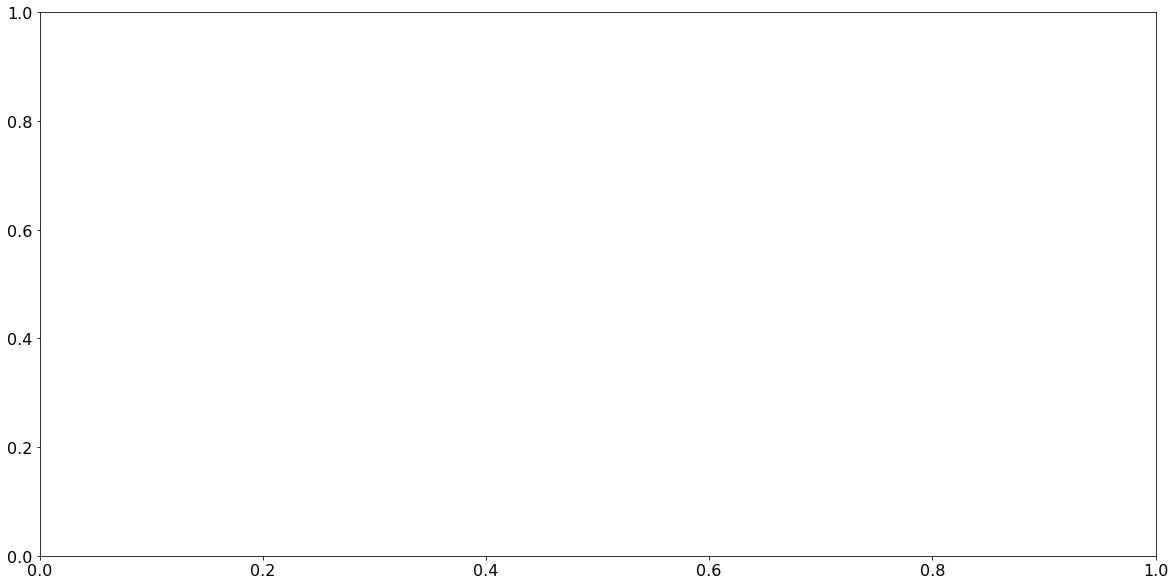

In [195]:
boxplot_date(atl06sr_gdf, 'diff_plus', clim=(-2,4), name = '../figures/boxplots_cdec_aso_radius17.jpeg')

In [ ]:
#https://datagy.io/pandas-conditional-column/

conditions = [
    (atl06sr_gdf['lidar_z'] < 914.4), # below 3k ft elevation (in this case, between 1345 and 3000 ft)
    (atl06sr_gdf['lidar_z'] >= 914.4) & (atl06sr_gdf['lidar_z'] < 1219.2), # between 3k and 4k ft elevation
    (atl06sr_gdf['lidar_z'] >= 1219.2) & (atl06sr_gdf['lidar_z'] < 1524), # between 4k and 5k ft. elevation
    (atl06sr_gdf['lidar_z'] >= 1524) & (atl06sr_gdf['lidar_z'] < 1828.8), # between 5k and 6k ft elevation
    (atl06sr_gdf['lidar_z'] >= 1828.8) # above 6k ft elevation (highest point is below 7k)
]
values = [2000, 3000, 4000, 5000, 6000]
atl06sr_gdf['elevation_band'] = np.select(conditions, values)